# Evolutionary Computation - Assignment 8: Global convexity (fitness-distance/similarity correlations) tests
Bartosz Stachowiak 148259<br>
Andrzej Kajdasz 148273

## 1. Problem Statement

There are columns of integers representing nodes. Each row corresponds to a node and contains its x and y coordinates in a plane, as well as a cost associated with the node. There were 4 such data sets each consisting of 200 rows (each representing a single node).

Problem to solve is to choose precisely 50% of the nodes (rounding up if there is an odd number of nodes) and create a Hamiltonian cycle (a closed path) using this subset of nodes. The goal is to minimize the combined total length of the path and the total cost of the selected nodes.

To calculate the distances between nodes, the Euclidean distance formula was used and then round the results to the nearest integer. As suggested, the distances between the nodes were calculated after loading the data and placed in a matrix, so that during the subsequent evaluation of the problem, it was only necessary to read these values which reduced the cost of the operation of the algorithm.

## 2. Results of the computational experiments

In [9]:
import json
import pathlib
import itertools

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from common import *

In [10]:
DATA_FOLDER = './data/'
OLD_RESULTS_FOLDER = f'{DATA_FOLDER}old_results/'
RESULT_FOLDER = f'{DATA_FOLDER}results/'
INSTANCE_FOLDER = f'{DATA_FOLDER}tsp_instances/'

SOLVERS = {
    "lsp-r" : "GreedyImprover",
}

OLD_SOLVERS = {
    "lsnp-10-r" : "LNS Steepest LS (D10)",
    "lsnp-20-r" : "LNS Steepest LS (D20)",
    "lsnp-30-r" : "LNS Steepest LS (D30)",
    "lsnp-50-r" : "LNS Steepest LS (D50)",
}
SOLVERS_TO_PLOT = SOLVERS.copy()
SOLVERS = {**OLD_SOLVERS, **SOLVERS}
NUM_NODES = 200

instance_files = [path for path in pathlib.Path(INSTANCE_FOLDER).iterdir() if path.is_file()]
instance_names = [path.name[:4] for path in instance_files]
p_sizes = [3, 5, 10, 20, 30, 50, 75]

In [11]:
instances_data = {
    name: read_instance(f'{INSTANCE_FOLDER}{name}.csv')
    for name in instance_names
}

In [12]:
instances_solvers_pairs = itertools.product(instances_data.keys(), SOLVERS.keys())

all_results = {}
all_costs = {}
all_times = {}
all_stats = {}

for instance, solver in instances_solvers_pairs:
    all_results[instance] = all_results.get(instance, {})
    all_costs[instance] = all_costs.get(instance, {})
    all_times[instance] = all_times.get(instance, {})
    all_stats[instance] = all_stats.get(instance, {})
    costs = []
    times = []
    paring_results = []
    NUMBER_OF_FILES = 20 if solver in OLD_SOLVERS else 1000
    for idx in range(NUMBER_OF_FILES):
        folder = OLD_RESULTS_FOLDER if solver in OLD_SOLVERS else RESULT_FOLDER
        if solver in OLD_SOLVERS:
            solution, cost, time, no_iterations = read_solution_three_feature(f'{folder}{instance}-{solver}-{idx}.txt')
        else:
            solution, cost, time = read_solution(f'{folder}{instance}-{solver}-{idx}.txt')
        paring_results.append(solution)
        costs.append(cost)
        times.append(time)
        
    all_results[instance][solver] = np.array(paring_results)
    all_costs[instance][solver] = np.array(costs)
    all_stats[instance][solver] = {
        'mean': np.mean(costs),
        'std': np.std(costs),
        'min': np.min(costs),
        'max': np.max(costs),
    }
    all_times[instance][solver] = {
        'mean': np.mean(times),
        'std': np.std(times),
        'min': np.min(times),
        'max': np.max(times),
    }

In [13]:
costs_df = pd.DataFrame(all_stats).T
time_df = pd.DataFrame(all_times).T
max_df = pd.DataFrame(all_stats).T
min_df = pd.DataFrame(all_stats).T
mean_time_df = pd.DataFrame(all_times).T

for column in SOLVERS.keys():
    costs_df[column] = costs_df[column].apply(lambda x: f'{x["mean"]:.0f} ({x["min"]:.0f} - {x["max"]:.0f})')
    time_df[column] = time_df[column].apply(lambda x: f'{x["mean"]/1000000:.2f} ({x["min"]/1000000:.2f} - {x["max"]/1000000:.2f})')
    max_df[column] = max_df[column].apply(lambda x: x['max'])
    min_df[column] = min_df[column].apply(lambda x: x['min'])
    mean_time_df[column] = mean_time_df[column].apply(lambda x: x['mean']/1000000)
    
for df in [costs_df, time_df, max_df, min_df, mean_time_df]:
    df.rename(columns=SOLVERS, inplace=True)

In [14]:
print("Mean (min-max) of the costs:")

best_means = {
    instance: min(all_stats[instance][solver]['mean'] for solver in SOLVERS.keys())
    for instance in instance_names
}

def apply_style(v: str, best_val: float):
    num = v.split()[0]
    try:
        num = float(num)
    except ValueError:
        return ""
    if round(num) == round(best_val):
        return "font-weight: bold; color: red"
    return ""
    


costs_df.T.style.apply(lambda x: [
    apply_style(v, best_means[x.index[i]])
    for i, v in enumerate(x)
], axis = 1)

Mean (min-max) of the costs:


,TSPA,TSPB,TSPC,TSPD
LNS Steepest LS (D10),73714 (72855 - 74473),67036 (66561 - 68437),47750 (47314 - 48255),44031 (43222 - 45007)
LNS Steepest LS (D20),73326 (72855 - 74074),66808 (66396 - 67741),47817 (47159 - 48480),43954 (43232 - 44747)
LNS Steepest LS (D30),73339 (72855 - 73937),66753 (66117 - 67401),47640 (46910 - 48770),44012 (43235 - 44937)
LNS Steepest LS (D50),73185 (72855 - 73449),66628 (66232 - 67109),47590 (47143 - 48450),44086 (43168 - 45523)
GreedyImprover,77846 (74982 - 82404),70765 (68007 - 77456),51595 (49151 - 54350),48580 (45689 - 53611)


# 3. Best solutions for all datasets and algorithms

To more easily compare the results, we present the best solutions for each dataset side by side.

The weight of each node is denoted both by its size and color. The bigger and brighter the node, the higher its weight.

TSPA
	Solver: LNS Steepest LS (D10), Total cost: 72855
	 Nodes: [0, 149, 50, 121, 91, 114, 4, 77, 43, 192, 199, 174, 137, 41, 177, 1, 75, 189, 109, 119, 130, 152, 11, 160, 106, 48, 92, 26, 8, 169, 95, 80, 14, 111, 31, 73, 89, 94, 12, 72, 190, 98, 156, 172, 6, 66, 112, 51, 135, 99, 101, 167, 45, 186, 127, 88, 153, 161, 76, 145, 128, 132, 36, 55, 22, 117, 15, 108, 171, 21, 194, 79, 87, 141, 144, 154, 81, 180, 32, 62, 53, 195, 113, 74, 163, 61, 71, 20, 64, 185, 96, 27, 116, 147, 59, 143, 159, 164, 178, 19]

TSPB
	Solver: LNS Steepest LS (D30), Total cost: 66117
	 Nodes: [0, 169, 66, 26, 92, 122, 143, 179, 121, 127, 24, 131, 103, 38, 101, 31, 197, 183, 34, 5, 2, 182, 163, 172, 95, 135, 198, 190, 19, 33, 29, 18, 16, 8, 63, 82, 115, 69, 53, 142, 130, 141, 148, 140, 174, 51, 70, 91, 156, 67, 158, 162, 150, 117, 196, 44, 71, 193, 119, 59, 166, 85, 114, 72, 171, 58, 89, 129, 64, 159, 147, 181, 170, 189, 12, 107, 139, 52, 132, 185, 73, 136, 79, 145, 157, 80, 153, 55, 88, 137, 37, 165, 36, 25, 13

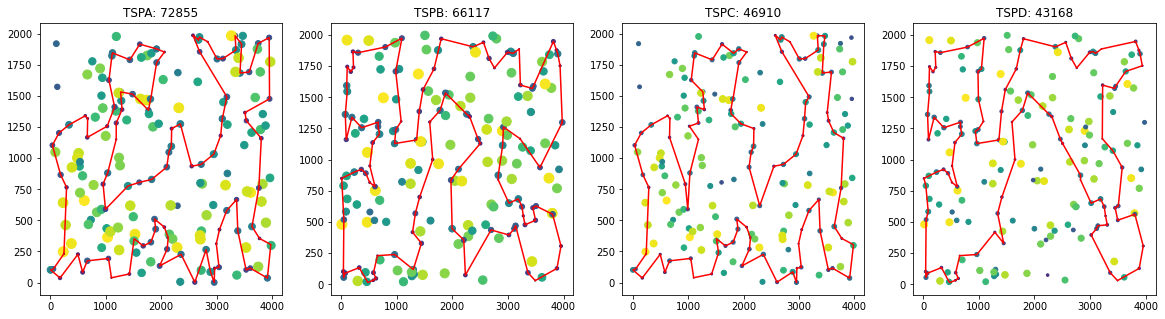

In [15]:
best_results = {}
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for idx, instance in enumerate(instances_data.keys()):
    best_cost =  np.inf
    for solver_idx, solver in enumerate(SOLVERS.keys()):
         if best_cost > np.min(all_costs[instance][solver]):
                best_cost = np.min(all_costs[instance][solver])
                best_result = all_results[instance][solver][np.argmin(all_costs[instance][solver])], 
                best_solver = solver
    best_instance_idx = np.argmin(all_costs[instance][best_solver])
    plot_solution_for_instance(instances_data[instance], all_results[instance][best_solver][best_instance_idx], axs[idx])
    axs[idx].set_title(f'{instance}: {all_costs[instance][best_solver][best_instance_idx]:.0f}')
    print(instance)
    print(f'\tSolver: {SOLVERS[best_solver]}, Total cost: {best_cost}')
    nodes = list(best_result[0])
    if 0 in best_result[0]:
        zero_index = np.where(best_result[0] == 0)[0][0]
        nodes = list(best_result[0][zero_index:])+list(best_result[0][:zero_index])
    print(f'\t Nodes: {nodes}\n')
    best_results[instance] = {"cost": best_cost, "nodes": nodes}
plt.show()

# 4. Similarity and Correlation

In [16]:
def common_similarity(x, y):
    return len(x.intersection(y))

def make_edges_from_nodes(nodes):
    edge = [nodes[0], nodes[-1]]
    edge.sort()
    edges = [tuple(edge)]
    for i in range(len(nodes)-1):
        edge = [nodes[i], nodes[i+1]]
        edge.sort()
        edges.append(tuple(edge))
    return set(edges)

def prepare_data(nodes):
    return (set(nodes), make_edges_from_nodes(nodes))

def pearson_correlation(x,y):
    return np.round(np.corrcoef(x, y)[0][1], 3)

def plot_similarity(similarity, title, similarity_y_label):
    fig, axs = plt.subplots(2, 2, figsize=(15, 11), sharey = True)
    axs[0][0].scatter(
        similarity["TSPA"]["costs"],
        similarity["TSPA"]["similarity"],
    )
    axs[0][1].scatter(
        similarity["TSPB"]["costs"],
        similarity["TSPB"]["similarity"],
    )

    axs[1][0].scatter(
        similarity["TSPC"]["costs"],
        similarity["TSPC"]["similarity"],
    )
    axs[1][1].scatter(
        similarity["TSPD"]["costs"],
        similarity["TSPD"]["similarity"],
    )
    
    correlation = pearson_correlation(similarity["TSPA"]["costs"], similarity["TSPA"]["similarity"])
    axs[0][0].set_title(f"TSPA, correlation {correlation}")
    axs[0][0].set_xlabel("Cost")
    axs[0][0].set_ylabel(f"Number of common {similarity_y_label}")
    
    correlation = pearson_correlation(similarity["TSPB"]["costs"], similarity["TSPB"]["similarity"])
    axs[0][1].set_title(f"TSPB, correlation {correlation}")
    axs[0][1].set_xlabel("Cost")
    axs[0][1].set_ylabel(f"Number of common {similarity_y_label}")

    correlation = pearson_correlation(similarity["TSPC"]["costs"], similarity["TSPC"]["similarity"])
    axs[1][0].set_title(f"TSPC, correlation {correlation}")
    axs[1][0].set_xlabel("Cost")
    axs[1][0].set_ylabel(f"Number of common {similarity_y_label}")

    correlation = pearson_correlation(similarity["TSPD"]["costs"], similarity["TSPD"]["similarity"])
    axs[1][1].set_title(f"TSPD, correlation {correlation}")
    axs[1][1].set_xlabel("Cost")
    axs[1][1].set_ylabel(f"Number of common {similarity_y_label}")

    fig.suptitle(title, fontsize=16)
    plt.show()

In [17]:
all_nodes = {}
all_edges = {}
for idx, instance in enumerate(instances_data.keys()):
    nodes, edges = prepare_data(best_results[instance]["nodes"])
    best_results[instance]["set_nodes"] = nodes
    best_results[instance]["edges"] = edges
    
    all_nodes[instance] = []
    all_edges[instance] = []
    for i in all_results[instance]["lsp-r"]:
        nodes, edges = prepare_data(i)
        all_nodes[instance].append(nodes)
        all_edges[instance].append(edges)

## 4.1 Node similarity between best result and all other local optima

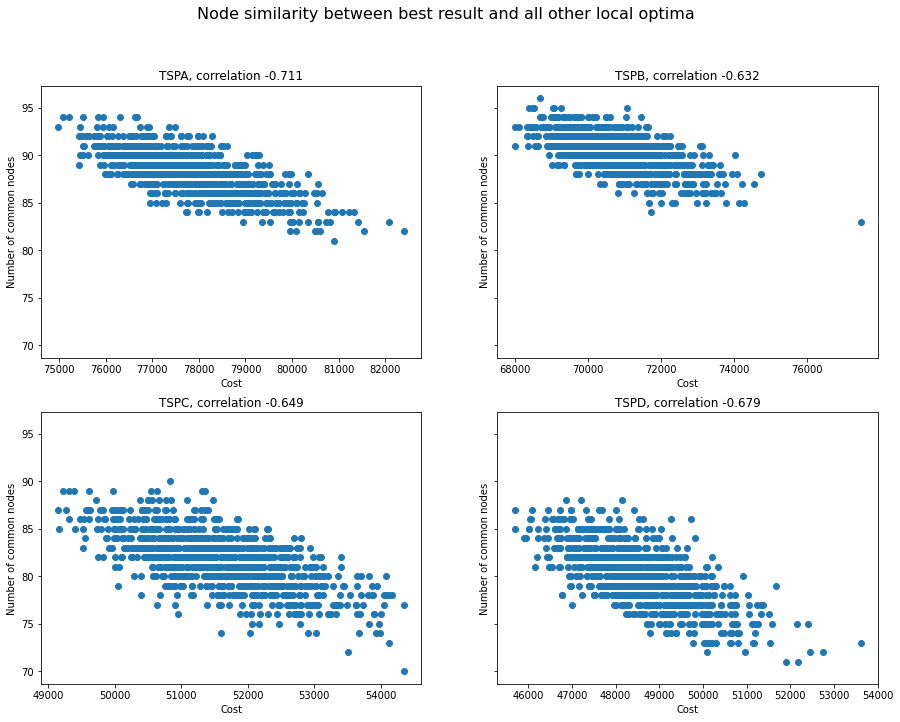

In [18]:
similarity = {}
for idx, instance in enumerate(instances_data.keys()):
    items = []
    similarity[instance] = {}
    for i in range (len(all_results[instance]["lsp-r"])):
        items.append([all_costs[instance]["lsp-r"][i], common_similarity(all_nodes[instance][i], best_results[instance]["set_nodes"])])
    similarity[instance]["costs"] = [n[0] for n in items]
    similarity[instance]["similarity"] = [n[1] for n in items]
plot_similarity(similarity, "Node similarity between best result and all other local optima", "nodes")

## 4.2 Edge similarity between best result and all other local optima

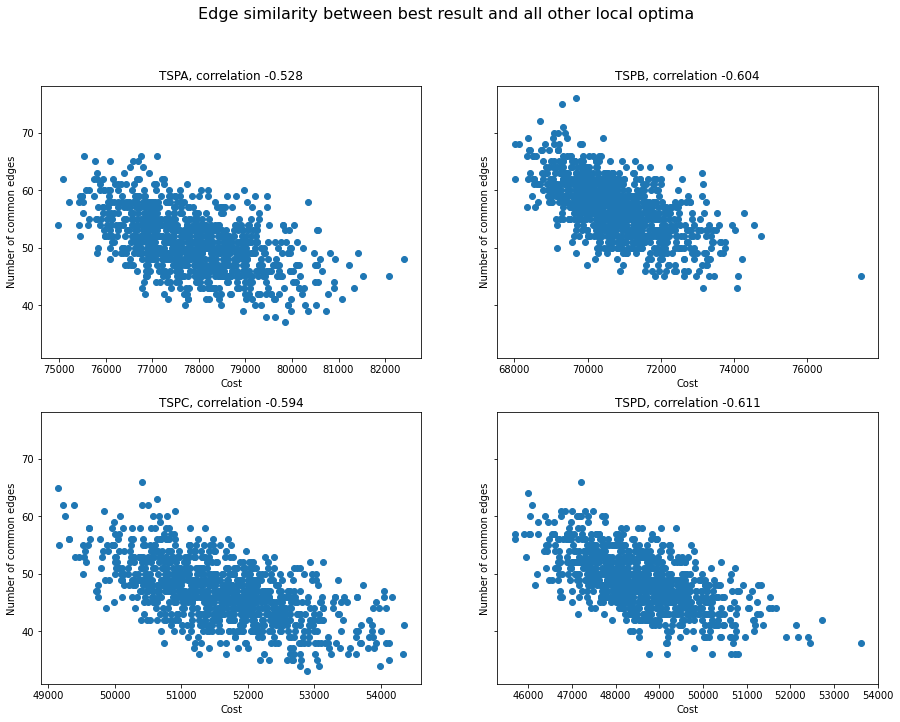

In [19]:
similarity = {}
for idx, instance in enumerate(instances_data.keys()):
    items = []
    similarity[instance] = {}
    for i in range (len(all_results[instance]["lsp-r"])):
        items.append([all_costs[instance]["lsp-r"][i], common_similarity(all_edges[instance][i], best_results[instance]["edges"])])
    similarity[instance]["costs"] = [n[0] for n in items]
    similarity[instance]["similarity"] = [n[1] for n in items]
plot_similarity(similarity, "Edge similarity between best result and all other local optima", "edges")

## 4.3 Node similarity between all other local optima

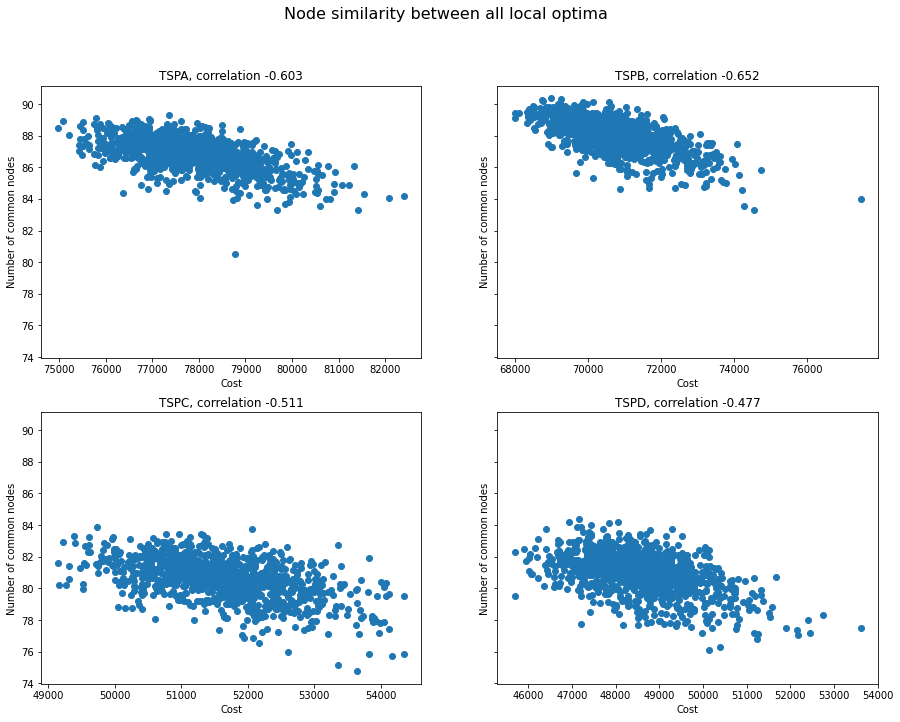

In [20]:
similarity = {}
for idx, instance in enumerate(instances_data.keys()):
    items = []
    similarity[instance] = {}
    for i in range (len(all_results[instance]["lsp-r"])):
        sum_similarity = 0
        for j in range (len(all_results[instance]["lsp-r"])):
            if i != j:
                sum_similarity += common_similarity(all_nodes[instance][i], all_nodes[instance][j])
        items.append([all_costs[instance]["lsp-r"][i], sum_similarity/999])
    similarity[instance]["costs"] = [n[0] for n in items]
    similarity[instance]["similarity"] = [n[1] for n in items]
plot_similarity(similarity, "Node similarity between all local optima", "nodes")

## 4.4 Edge similarity between all other local optima

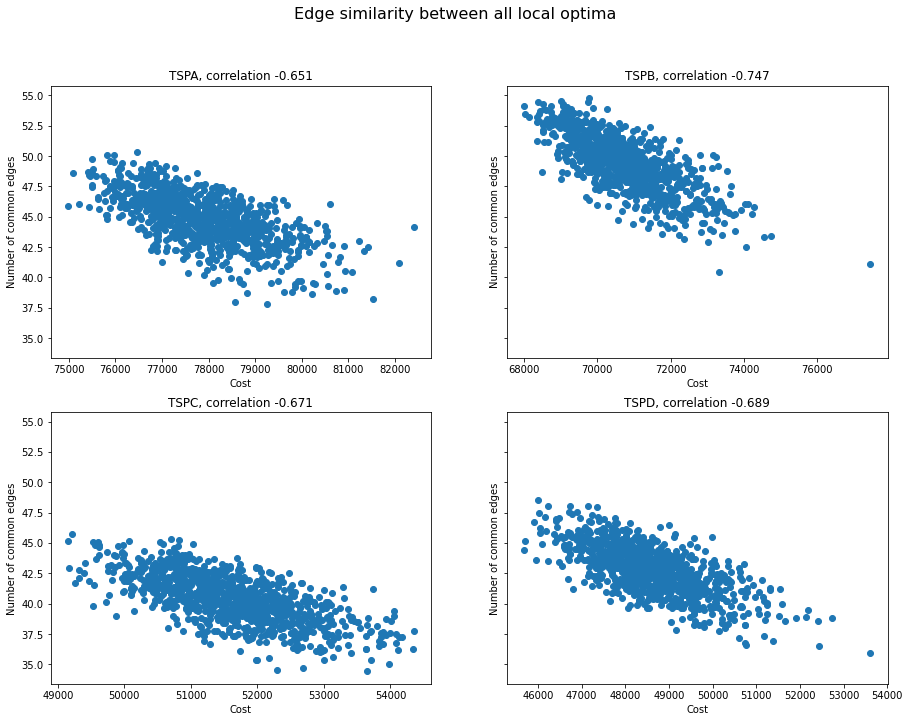

In [21]:
similarity = {}
for idx, instance in enumerate(instances_data.keys()):
    items = []
    similarity[instance] = {}
    for i in range (len(all_results[instance]["lsp-r"])):
        sum_similarity = 0
        for j in range (len(all_results[instance]["lsp-r"])):
            if i != j:
                sum_similarity += common_similarity(all_edges[instance][i], all_edges[instance][j])
        items.append([all_costs[instance]["lsp-r"][i], sum_similarity/999])
    similarity[instance]["costs"] = [n[0] for n in items]
    similarity[instance]["similarity"] = [n[1] for n in items]
plot_similarity(similarity, "Edge similarity between all local optima", "edges")

## 5. Source Code

[GitHub](https://github.com/Tremirre/ECP)

## 6. Conclusions



Analyzing the results and visualizations, one can come to several conclusions about the algorithms used in the task:
- For each of the cases presented, it can be seen that there is a negative correlation between the number of common nodes/edges and cost. 
- The correlation between the best solution found (LNS Steepest LS) and all local optima created by GreedyImprover:
    - for node similarity is medium, ranging between -0.679 and -0.711 depending on the instance. The number of common nodes ranges from 85-95 for TSPA and TSPB, and 75-90 for TSPC and TSPD.
    - for similarity calculated on the basis of shared edges, the correlation is lower (-0.528 to -0.611). There is a noticeable decrease in similarity as the number of common edges rarely exceeds 70. 
- The correlation between all local optima
    - in case of node similarity is the most diverse (-0.477 to -0.652). This is despite the fact that the average numbers of all common nodes are quite centralized and in each instance the MAX-MIN difference is less than 10.
    - for edge similarity the strongest correlation can be observed (-0.651 to -0.747). 
- It can be concluded that because most of the solutions found by GreedyImprover consist of many common nodes and the costs vary, the edges are more important and more correlated with the cost.